# Import library

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [24]:
thresh = 127
# calculating number of images in directory
for j in range(10):    
    _, _, images = next(os.walk("./images/"+str(j)))
    for i in range(len(images)+1):
        path = './images/'+str(j)+'/'+str(1)+'.jpg'
        image_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#         im_bw = cv2.threshold(image_gray, thresh, 255, cv2.THRESH_BINARY)[1]
        cv2.imwrite('./imagesG/'+str(j)+'/'+str(i)+'.jpg', image_gray)

# Image segmentation

In [2]:
nPlate = cv2.imread('sPlate.jpg')
cv2.imshow('s', nPlate)
cv2.waitKey(0)
cv2.destroyWindow('s')

In [3]:
gray = cv2.cvtColor(nPlate, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
bw = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)[1]
cv2.imshow('s', bw)
cv2.waitKey(0)
cv2.destroyWindow('s')

122.0
336.0
380.5
29.5
36.5
162.5
194.5
344.0


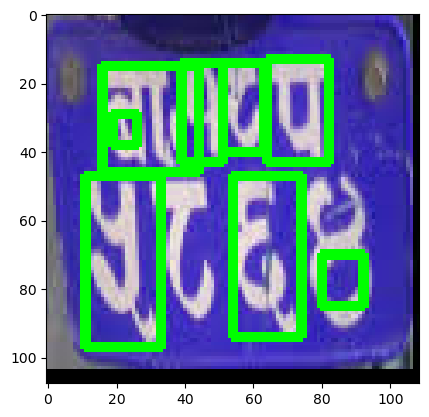

In [4]:
edges = cv2.Canny(blurred, 50, 150)
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(contours[0])
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(contour)
    
    if area > 20:
        print(area)
        filtered_contours.append(contour)
        cv2.rectangle(nPlate, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
# cv2.imshow('Detected Characters', nPlate)
plt.imshow(nPlate)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(contour)
    
#     print(aspect_ratio)
    if area > 20:
        filtered_contours.append(contour)
        cv2.rectangle(nPlate, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding rectangle
# for contour in filtered_contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     character = nPlate[y:y+h, x:x+w]
#     cv2.imshow('Character', character)
#     cv2.waitKey(0)
# Display image with bounding boxes
cv2.imshow('Detected Characters', nPlate)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
import cv2

harcascade = "./model/cascade.xml"

cap = cv2.VideoCapture('./video/2.mp4')

cap.set(3, 640) # width
cap.set(4, 480) #height

min_area = 500
count = 0

while True:
    success, img = cap.read()
    if success:
        plate_cascade = cv2.CascadeClassifier(harcascade)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        plates = plate_cascade.detectMultiScale(img_gray, 1.1, 4)

        for (x,y,w,h) in plates:
            area = w * h

            if area > min_area:
                cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
                cv2.putText(img, "Number Plate", (x,y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 255), 2)

                img_roi = img[y: y+h, x:x+w]
                cv2.imshow("ROI", img_roi)
#                 cv2.imwrite("plates/scaned_img_" + str(count) + ".jpg", img_roi)



        cv2.imshow("Result", img)
        if cv2.waitKey(1) & 0xFF == ord('s'):
            cv2.imwrite("plates/scaned_img_" + str(count) + ".jpg", img_roi)
            cv2.rectangle(img, (0,200), (640,300), (0,255,0), cv2.FILLED)
            cv2.putText(img, "Plate Saved", (150, 265), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (0, 0, 255), 2)
            cv2.imshow("Results",img)
            cv2.waitKey(0)
            cv2.destroyWindow('Results')
            count += 1
            break;
    else:
#         cv2.destroyWindow('Result')
#         cv2.destroyWindow('ROI')
        break;


KeyboardInterrupt: 

In [1]:
import cv2

def draw_boundary(event, x, y, flags, param):
    global start_x, start_y, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_x, start_y = x, y
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_x, end_y = x, y
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 0)
        cv2.imshow("Image", image)

        # Extract and display the selected region
        selected_region = image[start_y:end_y, start_x:end_x]
        cv2.imshow("Selected Region", selected_region)
#         cv2.imwrite('./plates/1.jpg', selected_region)
        cv2.waitKey(0)  # Wait until a key is pressed

# image = cv2.imread("sPlate.jpg")
# cv2.namedWindow("Image")
# cv2.setMouseCallback("Image", draw_boundary)

# drawing = False
# start_x, start_y = -1, -1

# while True:
#     cv2.imshow("Image", image)
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord("q"):
#         break

# cv2.destroyAllWindows()


In [1]:
import cv2
import os

# Open the video file
video_path = "./video/2.mp4"
cap = cv2.VideoCapture(video_path)

# Check if the video file was opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Directory to save the frames
output_dir = "./plates"
os.makedirs(output_dir, exist_ok=True)

frame_count = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        break  # Break the loop if we've reached the end of the video

    # Save the frame as an image file
    frame_filename = os.path.join(output_dir, f"{frame_count:}.png")
    cv2.imwrite(frame_filename, frame)

    frame_count += 1

# Release the video capture object
cap.release()

print(f"Saved {frame_count} frames to {output_dir}")


KeyboardInterrupt: 

In [ ]:
count = 0;
def draw_boundary(event, x, y, flags, param):
    global count;
    global start_x, start_y, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_x, start_y = x, y
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_x, end_y = x, y
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 0)
        cv2.imshow("Image", image)

        # Extract and display the selected region
        selected_region = image[start_y:end_y, start_x:end_x]
#         cv2.imshow("Selected Region", selected_region)
        cv2.imwrite('./newN/'+str(count)+'.jpg', selected_region)
        count = count+1;
#         print(count)
        cv2.waitKey(0)  # Wait until a key is pressed

In [ ]:
import cv2
import os

# Directory containing your images
images_dir = "./plates"

# Get a list of image filenames in the directory
image_files = [file for file in os.listdir(images_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(images_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    
    if image is not None:
        # Display the image
        cv2.imshow("Image", image)
        cv2.namedWindow("Image")
        cv2.setMouseCallback("Image", draw_boundary)
        # Wait for a key press and close the window if 'q' is pressed
        key = cv2.waitKey(0)
        if key == ord('q'):
            break

# Close the OpenCV windows
cv2.destroyAllWindows()


In [4]:
import os
import glob
import cv2
from PIL import Image
image_paths = glob.glob(os.path.join('./nPlates/p', '*.jpg')) 

In [7]:
i = 0;
for image_path in image_paths:
    img = cv2.imread(image_path)
    # Process the image here
    # Get the height and width of the image
#     height, width = img.shape[:2]

#     # Define the rotation angle (in degrees)
#     angle = -10

#     # Calculate the rotation matrix
#     rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

#     # Apply the rotation to the image
#     rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
#     mirrored_image_horizontal = cv2.flip(rotated_image, 1)
    cv2.imshow('Image', img)  # Example: Display the image
    i = i+1
    cv2.imwrite('./temp/'+str(i)+'.jpg', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
